In [4]:
import numpy as np
import pandas as pd
import networkx as nx
from enum import IntEnum
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from mesa import Model, Agent
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.batchrunner import batch_run
from mesa.datacollection import DataCollector

# 1. Modeling Austria

### Age distribution
https://wibis-steiermark.at/bevoelkerung/struktur/einwohner-nach-altersklassen/

In [5]:
def get_age():
    age_ranges = [(0, 15), (15, 20), (20, 25), (25, 30), (30, 45), (45, 60), (60, 65), (65, 75), (75, 101)]
    total_population = 9104772
    age_population = [1315044, 446517, 502389, 592713, 1866278, 1970352, 630776, 913691, 867012]
    age_percentages = [age / total_population for age in age_population]

    age_range = np.random.choice(len(age_ranges), p=age_percentages)
    min_age, max_age = age_ranges[age_range]
    age = np.random.randint(min_age, max_age)

    return age

### Death rate by age until end 2021
https://www.statistik.at/fileadmin/announcement/2022/05/20220125SterberatenImpfstatus.pdf

In [6]:
def get_death_prob(age):
    age_groups = [(0, 20), (20, 40), (40, 60), (60, 80), (80, 101)]
    deaths_per_age_group = [15, 35, 212, 1430, 9560]
    sample_size = 100000
    deaths_percentages = [death / sample_size for death in deaths_per_age_group]

    index = next((i for i, (start, end) in enumerate(age_groups) if start <= age < end), None)
    return deaths_percentages[index]

# 2. SIR Model Basic

### 2.1 Collector Functions

In [7]:
def get_number_of_deaths(model):
    return len(model.dead_agents)

In [8]:
def get_number_of_infected(model):
    return model.total_infections

### 2.2 States

In [9]:
class State(IntEnum):
    SUSCEPTIBLE = 0
    INFECTED = 1
    REMOVED = 2

### 2.3 Agent Basic

In [10]:
class SIRAgentBasic(Agent):

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.age = get_age()
        model.agent_ages.append(self.age)
        self.death_prob = get_death_prob(self.age)
        self.state = State.SUSCEPTIBLE
        self.infection_time = 0

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def status(self):
        if self.state == State.INFECTED:
            if np.random.random() < self.death_prob: # chance of "dying"
                self.model.schedule.remove(self)
                self.model.dead_agents.append(self)
            else:
                t = self.model.schedule.time - self.infection_time
                if t >= self.recovery_time:
                    self.state = State.REMOVED

    def contact(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        for other in cellmates:
            if self.random.random() <= self.model.ptrans: # transmission probability
                if (self.state is State.INFECTED and other.state is State.SUSCEPTIBLE):
                    other.state = State.INFECTED
                    other.infection_time = self.model.schedule.time
                    other.recovery_time = self.model.get_recovery_time()
                    other.model.total_infections += 1

    def step(self):
        self.status()
        self.move()
        self.contact()

### 2.4 Model Basic

In [11]:
class SIRModelBasic(Model):
    def __init__(self, N, ptrans, recovery_days, recovery_sd, initial_infections, width, height):

        super().__init__()

        self.num_agents = N
        self.ptrans = ptrans
        self.recovery_days = recovery_days
        self.recovery_sd = recovery_sd

        self.grid = MultiGrid(width, height, True) # each cell can contain more than one agent
        self.schedule = RandomActivation(self)
        self.running = True

        self.agent_ages = []
        self.dead_agents = []
        self.total_infections = 0

        self.datacollector = DataCollector(
            model_reporters={"Nr_Deaths": get_number_of_deaths, "Nr_Infections": get_number_of_infected},
            agent_reporters={"State": "state"})

        # Create agents
        for id in range(self.num_agents):
            agent = SIRAgentBasic(id, self)
            self.schedule.add(agent)

            # Place random on grid
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(agent, (x, y))

            # Make some agents infected at start
            infected = np.random.choice([False, True], p=[1 - initial_infections, initial_infections])
            if infected:
                agent.state = State.INFECTED
                agent.recovery_time = self.get_recovery_time()

    # Calculates recovery time for an agent based on a normal distribution
    # with mean (recovery_days) and standard deviation (recovery_sd).
    def get_recovery_time(self):
        return int(self.random.normalvariate(self.recovery_days, self.recovery_sd))

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

### 2.5 Run Basic ISR Model

#### Model Parameters:
* N = Number of agents
* ptrans = transmission probability
* recovery_days & sd = params for normal distribution of recovery time
* initial_infections = probability a agents is infected at step 0
* Grid width and height



### 2.5.1 Pseudo Batch Runner

In [12]:
def pseudo_batch_runner_basic(nr_of_runs, params):
    model_ages = []
    agent_basic_out = []
    model_basic_out = []

    for i in range(nr_of_runs):
        model_basic = SIRModelBasic(params['N'], params['ptrans'], params['recovery_days'], params['recovery_sd'],
                                    params['initial_infections'], params['width'], params['height'])

        while model_basic.schedule.steps < 100:
            model_basic.step()

        print(f'Iteration {i}: Basic Infection Model ran for {model_basic.schedule.steps} steps')
        model_ages.extend(model_basic.agent_ages)
        agent_basic_out.append(model_basic.datacollector.get_agent_vars_dataframe())
        model_basic_out.append(model_basic.datacollector.get_model_vars_dataframe())

    agent_runs_df = pd.concat(agent_basic_out, ignore_index=False)
    mean_agent_runs_df = agent_runs_df.groupby("Step").value_counts() / nr_of_runs
    states_over_steps = mean_agent_runs_df.unstack(fill_value=0)

    model_runs_df = pd.concat(model_basic_out, ignore_index=False)
    mean_model_runs_df = model_runs_df.groupby(model_runs_df.index).mean()

    print("\n")

    return states_over_steps, mean_model_runs_df, model_ages



### 2.5.2 Different Transmission probabilities of 10%, 50%, 90%

In [ ]:
params = {'N': 1000,
          'ptrans': 0.1,
          'recovery_days': 21,
          'recovery_sd': 7,
          'initial_infections': 0.02,
          'width': 50,
          'height': 50}

states_10, deaths_10, ages_10 = pseudo_batch_runner_basic(10, params)

params['ptrans'] = 0.5
states_50, deaths_50, _ = pseudo_batch_runner_basic(10, params)

params['ptrans'] = 0.9
states_90, deaths_90, _ = pseudo_batch_runner_basic(10, params)

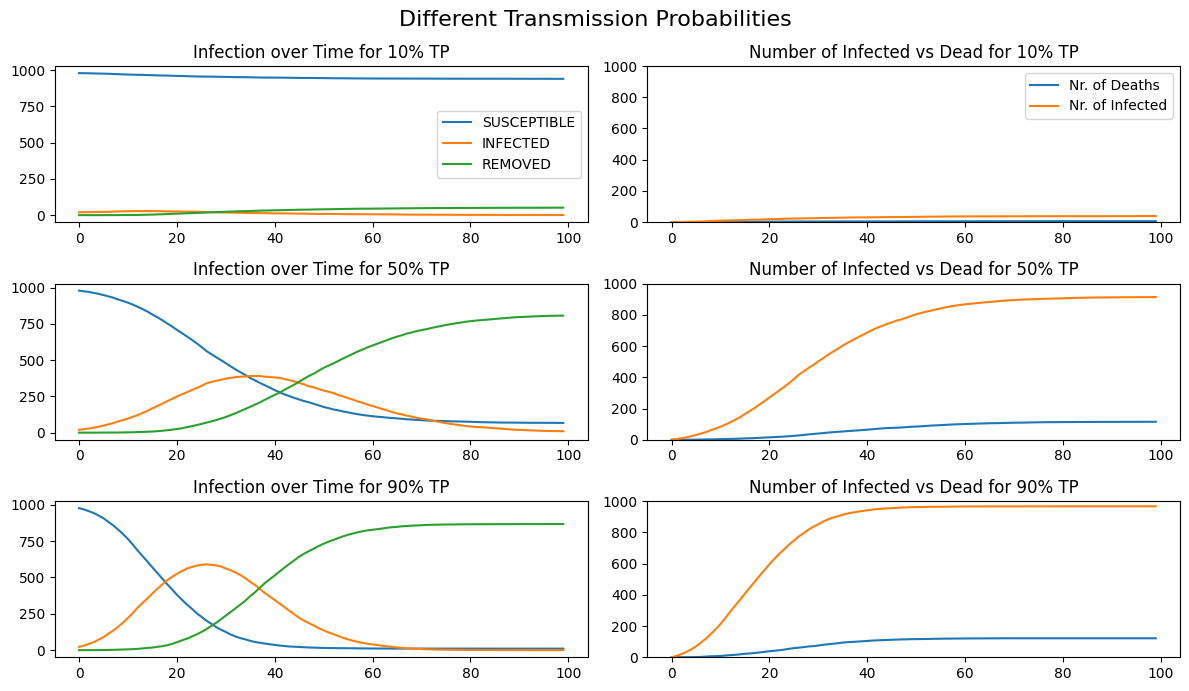

In [14]:
fig = plt.figure(figsize=(12, 7))

# TP 10%
plt.subplot(3, 2, 1)
plt.plot(states_10[0], label='SUSCEPTIBLE')
plt.plot(states_10[1], label='INFECTED')
plt.plot(states_10[2], label='REMOVED')
plt.legend(loc='center right')
plt.title("Infection over Time for 10% TP")

plt.subplot(3, 2, 2)
plt.plot(deaths_10['Nr_Deaths'], label='Nr. of Deaths')
plt.plot(deaths_10['Nr_Infections'], label='Nr. of Infected')
plt.title("Number of Infected vs Dead for 10% TP")
plt.ylim([0, 1000])
plt.legend()

# TP 50%
plt.subplot(3, 2, 3)
plt.plot(states_50[0], label='SUSCEPTIBLE')
plt.plot(states_50[1], label='INFECTED')
plt.plot(states_50[2], label='REMOVED')
plt.title("Infection over Time for 50% TP")

plt.subplot(3, 2, 4)
plt.plot(deaths_50['Nr_Deaths'], label='Nr. of Deaths')
plt.plot(deaths_50['Nr_Infections'], label='Nr. of Infected')
plt.title("Number of Infected vs Dead for 50% TP")
plt.ylim([0, 1000])

# TP 90%
plt.subplot(3, 2, 5)
plt.plot(states_90[0], label='SUSCEPTIBLE')
plt.plot(states_90[1], label='INFECTED')
plt.plot(states_90[2], label='REMOVED')
plt.title("Infection over Time for 90% TP")

plt.subplot(3, 2, 6)
plt.plot(deaths_90['Nr_Deaths'], label='Nr. of Deaths')
plt.plot(deaths_90['Nr_Infections'], label='Nr. of Infected')
plt.title("Number of Infected vs Dead for 90% TP")
plt.ylim([0, 1000])

plt.suptitle("Different Transmission Probabilities", fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.90)

plt.savefig('transmission_prob.png', dpi=300)
plt.savefig('transmission_prob.pdf')

plt.show()

### 2.5.3 Example Age Distribution

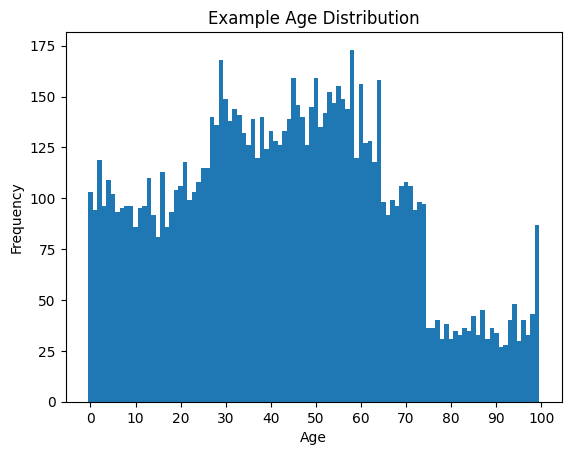

In [15]:
plt.hist(ages_10, bins=range(101), align='left')
plt.xticks(range(0, 101, 10))
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Example Age Distribution')

plt.savefig('example_age_disribution.png', dpi=300)
plt.savefig('example_age_disribution.pdf')
plt.show()

### 2.5.4 Test different grid sizes with a fixed 50% transmission probabilities

In [ ]:
params = {'N': 1000,
          'ptrans': 0.5,
          'recovery_days': 21,
          'recovery_sd': 7,
          'initial_infections': 0.02,
          'width': 15,
          'height': 15}

states_15x15, deaths_15x15, _ = pseudo_batch_runner_basic(10, params)

params['width'] = 35
params['height'] = 35
states_35x35, deaths_35x35, _ = pseudo_batch_runner_basic(10, params)

params['width'] = 55
params['height'] = 55
states_50x50, deaths_50x50, _ = pseudo_batch_runner_basic(10, params)

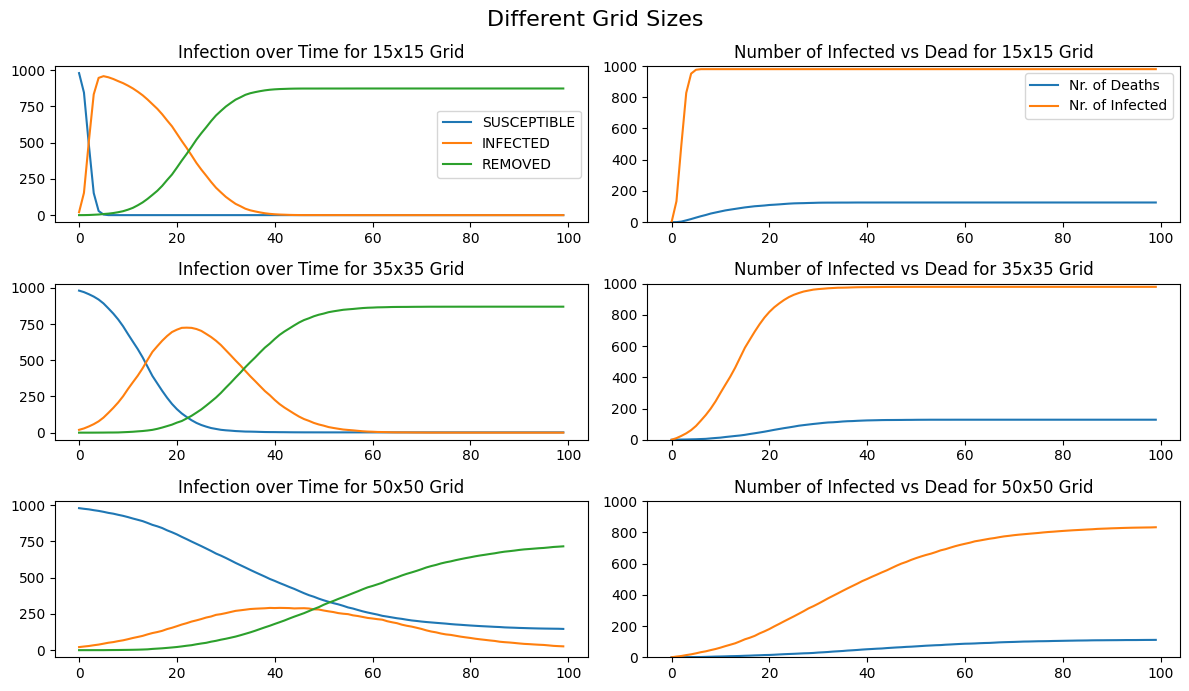

In [17]:
fig = plt.figure(figsize=(12, 7))

# 15x15
plt.subplot(3, 2, 1)
plt.plot(states_15x15[0], label='SUSCEPTIBLE')
plt.plot(states_15x15[1], label='INFECTED')
plt.plot(states_15x15[2], label='REMOVED')
plt.legend(loc='center right')
plt.title("Infection over Time for 15x15 Grid")

plt.subplot(3, 2, 2)
plt.plot(deaths_15x15['Nr_Deaths'], label='Nr. of Deaths')
plt.plot(deaths_15x15['Nr_Infections'], label='Nr. of Infected')
plt.title("Number of Infected vs Dead for 15x15 Grid")
plt.ylim([0, 1000])
plt.legend()

# 35x35
plt.subplot(3, 2, 3)
plt.plot(states_35x35[0], label='SUSCEPTIBLE')
plt.plot(states_35x35[1], label='INFECTED')
plt.plot(states_35x35[2], label='REMOVED')
plt.title("Infection over Time for 35x35 Grid")

plt.subplot(3, 2, 4)
plt.plot(deaths_35x35['Nr_Deaths'], label='Nr. of Deaths')
plt.plot(deaths_35x35['Nr_Infections'], label='Nr. of Infected')
plt.title("Number of Infected vs Dead for 35x35 Grid")
plt.ylim([0, 1000])

# 50x50
plt.subplot(3, 2, 5)
plt.plot(states_50x50[0], label='SUSCEPTIBLE')
plt.plot(states_50x50[1], label='INFECTED')
plt.plot(states_50x50[2], label='REMOVED')
plt.title("Infection over Time for 50x50 Grid")

plt.subplot(3, 2, 6)
plt.plot(deaths_50x50['Nr_Deaths'], label='Nr. of Deaths')
plt.plot(deaths_50x50['Nr_Infections'], label='Nr. of Infected')
plt.title("Number of Infected vs Dead for 50x50 Grid")
plt.ylim([0, 1000])

plt.suptitle("Different Grid Sizes", fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.90)

plt.savefig('grid_sizes.png', dpi=300)
plt.savefig('grid_sizes.pdf')
plt.show()

# 3. SIR Model with Vaccination

### 3.1 Agent Vaccination

In [18]:
class SIRAgentVaccinated(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.age = get_age()
        model.agent_ages.append(self.age)
        self.death_prob = get_death_prob(self.age)
        self.state = State.SUSCEPTIBLE
        self.infection_time = 0
        self.vaccinated = False

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def status(self):
        if self.state == State.INFECTED:
            if np.random.random() < self.death_prob: # chance of "dying"
                self.model.schedule.remove(self)
                self.model.dead_agents.append(self)
            else:
                t = self.model.schedule.time - self.infection_time
                if t >= self.recovery_time:
                    self.state = State.REMOVED

    def contact(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        for other in cellmates:
            if self.random.random() <= self.model.ptrans: #  transmission probability
                if (self.state is State.INFECTED and other.state is State.SUSCEPTIBLE):
                    if not other.vaccinated or np.random.random() > other.model.vaccination_protection:
                        other.state = State.INFECTED
                        other.infection_time = self.model.schedule.time
                        other.recovery_time = self.model.get_recovery_time()

    def step(self):
        self.status()
        self.move()
        self.contact()

### 3.2 Model Vaccination

In [19]:
class SIRModelVaccinated(Model):
    def __init__(self, N, ptrans, vacc_protection, vaccination_time, vacc_proportion, recovery_days, recovery_sd,
                 initial_infections, width, height):

        super().__init__()

        self.num_agents = N
        self.ptrans = ptrans
        self.vaccination_protection = vacc_protection
        self.time_of_vaccination = vaccination_time
        self.proportion_of_vaccines = vacc_proportion
        self.recovery_days = recovery_days
        self.recovery_sd = recovery_sd

        self.grid = MultiGrid(width, height, True) # each cell can contain more than one agent
        self.schedule = RandomActivation(self)
        self.running = True

        self.agent_ages = []
        self.dead_agents = []

        self.datacollector = DataCollector(
            model_reporters={"Nr_Deaths": get_number_of_deaths},
            agent_reporters={"State": "state"})

        # Create agents
        for id in range(self.num_agents):
            agent = SIRAgentVaccinated(id, self)
            self.schedule.add(agent)

            # Place random on grid
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(agent, (x, y))

            # Make some agents infected at start
            infected = np.random.choice([False, True], p=[1 - initial_infections, initial_infections])
            if infected:
                agent.state = State.INFECTED
                agent.recovery_time = self.get_recovery_time()

    # Calculates recovery time for an agent based on a normal distribution
    # with mean (recovery_days) and standard deviation (recovery_sd).
    def get_recovery_time(self):
        return int(self.random.normalvariate(self.recovery_days, self.recovery_sd))

    def step(self):
        self.datacollector.collect(self)

        if self.schedule.time == self.time_of_vaccination: # At step t vaccinate proportion of agents
            num_agents = len(self.schedule.agents)
            num_to_sample = int(self.proportion_of_vaccines * num_agents)
            sampled_agents = np.random.choice(self.schedule.agents, size=num_to_sample, replace=True)
            for agent in sampled_agents:
                agent.vaccinated = True

        self.schedule.step()

### 3.3 Pseudo Batch Runner Vaccination


In [20]:
def pseudo_batch_runner_vaccinated(nr_of_runs, params):
    agent_basic_out = []

    for i in range(nr_of_runs):
        model_vac = SIRModelVaccinated(params['N'], params['ptrans'], params['vacc_protection'], params['vaccination_time'],
                                       params['vacc_proportion'], params['recovery_days'], params['recovery_sd'],
                                       params['initial_infections'], params['width'], params['height'])

        while model_vac.schedule.steps < 100:
            model_vac.step()

        print(f'Iteration {i}: Vaccination Infection Model ran for {model_vac.schedule.steps} steps')
        agent_basic_out.append(model_vac.datacollector.get_agent_vars_dataframe())

    agent_runs_df = pd.concat(agent_basic_out, ignore_index=False)
    mean_agent_runs_df = agent_runs_df.groupby("Step").value_counts() / nr_of_runs
    states_over_steps = mean_agent_runs_df.unstack(fill_value=0)

    print("\n")

    return states_over_steps

### 3.4 Vaccination at time stamps 18, 9, 0 and 80% of the agents get vaccinated

Vacination protects you with a probability of 80%, TP 50%

In [ ]:
params = {'N': 1000,
          'ptrans': 0.5,
          'vacc_protection': 0.8,
          'vaccination_time': 18,
          'vacc_proportion': 0.8,
          'recovery_days': 21,
          'recovery_sd': 7,
          'initial_infections': 0.02,
          'width': 35,
          'height': 35}

step_15 = pseudo_batch_runner_vaccinated(10, params)

params['vaccination_time'] = 9
step_5 = pseudo_batch_runner_vaccinated(10, params)

params['vaccination_time'] = 0
step_0 = pseudo_batch_runner_vaccinated(10, params)

### 3.5 Compare difference when 50% 75% 100% of the agents get vaccinated at step 5

In [ ]:
params = {'N': 1000,
          'ptrans': 0.5,
          'vacc_protection': 0.8,
          'vaccination_time': 5,
          'vacc_proportion': 0.5,
          'recovery_days': 21,
          'recovery_sd': 7,
          'initial_infections': 0.02,
          'width': 35,
          'height': 35}

prop_50 = pseudo_batch_runner_vaccinated(10, params)

params['vacc_proportion'] = 0.75
prop_75 = pseudo_batch_runner_vaccinated(10, params)

params['vacc_proportion'] = 1
prop_100 = pseudo_batch_runner_vaccinated(10, params)

### 3.6 Visualize Vaccination Impact

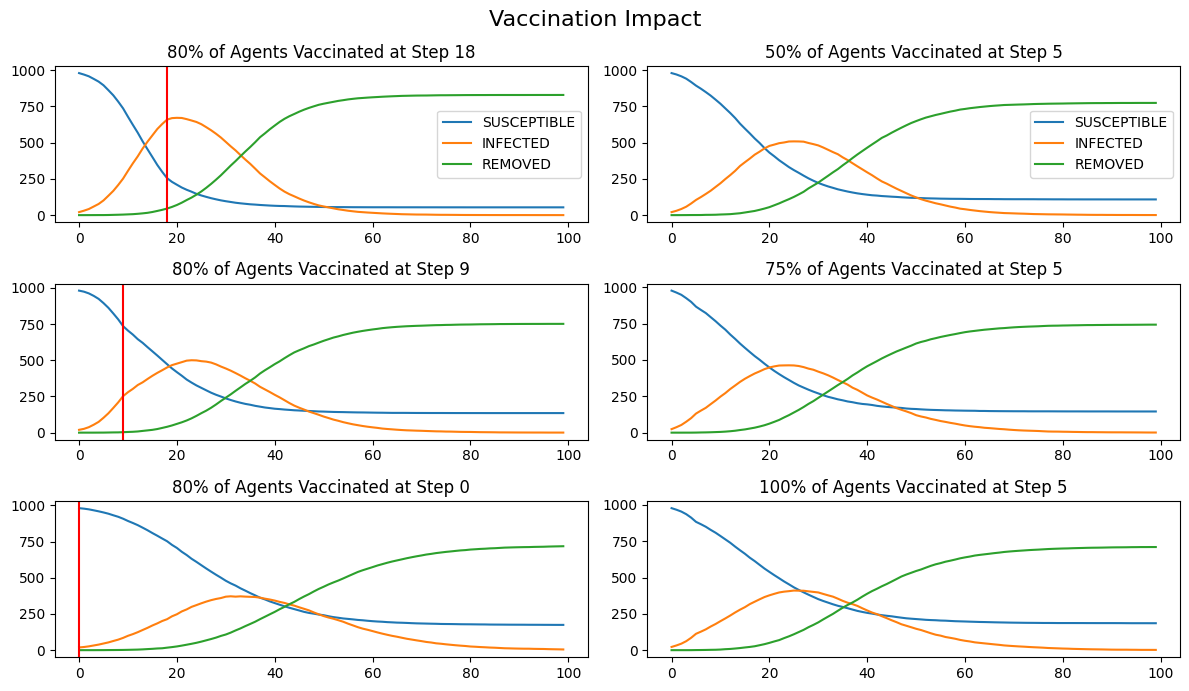

In [24]:
fig = plt.figure(figsize=(12, 7))

# step 15
plt.subplot(3, 2, 1)
plt.plot(step_15[0], label='SUSCEPTIBLE')
plt.plot(step_15[1], label='INFECTED')
plt.plot(step_15[2], label='REMOVED')
plt.legend(loc='center right')
plt.axvline(x=18, color='red')
plt.title("80% of Agents Vaccinated at Step 18")

# 50% of agentes vaccinated
plt.subplot(3, 2, 2)
plt.plot(prop_50[0], label='SUSCEPTIBLE')
plt.plot(prop_50[1], label='INFECTED')
plt.plot(prop_50[2], label='REMOVED')
plt.legend(loc='center right')
plt.title("50% of Agents Vaccinated at Step 5")

# step 5
plt.subplot(3, 2, 3)
plt.plot(step_5[0], label='SUSCEPTIBLE')
plt.plot(step_5[1], label='INFECTED')
plt.plot(step_5[2], label='REMOVED')
plt.axvline(x=9, color='red')
plt.title("80% of Agents Vaccinated at Step 9")

# 75% of agentes vaccinated
plt.subplot(3, 2, 4)
plt.plot(prop_75[0], label='SUSCEPTIBLE')
plt.plot(prop_75[1], label='INFECTED')
plt.plot(prop_75[2], label='REMOVED')
plt.title("75% of Agents Vaccinated at Step 5")

# step 0
plt.subplot(3, 2, 5)
plt.plot(step_0[0], label='SUSCEPTIBLE')
plt.plot(step_0[1], label='INFECTED')
plt.plot(step_0[2], label='REMOVED')
plt.axvline(x=0, color='red')
plt.title("80% of Agents Vaccinated at Step 0")

# 100% of agentes vaccinated
plt.subplot(3, 2, 6)
plt.plot(prop_100[0], label='SUSCEPTIBLE')
plt.plot(prop_100[1], label='INFECTED')
plt.plot(prop_100[2], label='REMOVED')
plt.title("100% of Agents Vaccinated at Step 5")

plt.suptitle("Vaccination Impact", fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.90)

plt.savefig('vaccination_impact.png', dpi=300)
plt.savefig('vaccination_impact.pdf')
plt.show()

# 4. Identify Most Influential Spreader

### 4.1 k-shell decomposition

In [25]:
def k_shell_decomposition(G):
    k = 1
    k_shell_indices = {}

    while G.number_of_nodes() > 0:
        while True:
            nodes_to_remove = []
            for node in G:
                if G.degree(node) <= k:
                    k_shell_indices[node] = k
                    nodes_to_remove.append(node)

            if len(nodes_to_remove) == 0:
                break

            G.remove_nodes_from(nodes_to_remove)
        k+=1

    sorted_nodes = sorted(k_shell_indices.items(), key=lambda x: x[1], reverse=True)
    highest_k_shell_index = sorted_nodes[0][1]

    return [node for node, degree in sorted_nodes if degree == highest_k_shell_index]

### 4.2 Start with SIR Model
#### 4.2.1 SIR Agent with Vaccination

In [26]:
class SIRAgentVaccinatedSpreader(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.age = get_age()
        model.agent_ages.append(self.age)
        self.death_prob = get_death_prob(self.age)
        self.state = State.SUSCEPTIBLE
        self.infection_time = 0
        self.contact_list = []
        self.vaccinated = False

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def status(self):
        if self.state == State.INFECTED:
            if np.random.random() < self.death_prob: # chance of "dying"
                self.model.schedule.remove(self)
                self.model.dead_agents.append(self)
            else:
                t = self.model.schedule.time - self.infection_time
                if t >= self.recovery_time:
                    self.state = State.REMOVED

    def contact(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        for other in cellmates:
            if self.random.random() <= self.model.ptrans: #  transmission probability
                if (self.state is State.INFECTED and other.state is State.SUSCEPTIBLE):
                    if not other.vaccinated or np.random.random() > other.model.vaccination_protection:
                        other.state = State.INFECTED
                        other.infection_time = self.model.schedule.time
                        other.recovery_time = self.model.get_recovery_time()
                        self.contact_list.append(other.unique_id)

    def step(self):
        self.status()
        self.move()
        self.contact()

#### 4.2.2 SIR Model with Vaccination

In [27]:
class SIRModelVaccinatedSpreader(Model):
    def __init__(self, N, ptrans, vacc_protection, vaccination_time, vacc_proportion, recovery_days, recovery_sd,
                 initial_infections, width, height):

        super().__init__()

        self.num_agents = N
        self.ptrans = ptrans
        self.vaccination_protection = vacc_protection
        self.time_of_vaccination = vaccination_time
        self.proportion_of_vaccines = vacc_proportion
        self.recovery_days = recovery_days
        self.recovery_sd = recovery_sd

        self.grid = MultiGrid(width, height, True) # each cell can contain more than one agent
        self.schedule = RandomActivation(self)
        self.running = True

        self.agent_ages = []
        self.dead_agents = []

        self.datacollector = DataCollector(
            model_reporters={"Nr_Deaths": get_number_of_deaths},
            agent_reporters={"State": "state"})

        # Create agents
        for id in range(self.num_agents):
            agent = SIRAgentVaccinatedSpreader(id, self)
            self.schedule.add(agent)

            # Place random on grid
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(agent, (x, y))

        # Only make one agent infected
        first_agent = self.schedule.agents[0]
        first_agent.state = State.INFECTED
        first_agent.recovery_time = self.get_recovery_time()

    # Calculates recovery time for an agent based on a normal distribution
    # with mean (recovery_days) and standard deviation (recovery_sd).
    def get_recovery_time(self):
        return int(self.random.normalvariate(self.recovery_days, self.recovery_sd))

    def step(self):
        self.datacollector.collect(self)

        if self.schedule.time == self.time_of_vaccination: # At step t vaccinate proportion of agents
            num_agents = len(self.schedule.agents)
            num_to_sample = int(self.proportion_of_vaccines * num_agents)
            sampled_agents = np.random.choice(self.schedule.agents, size=num_to_sample, replace=True)
            for agent in sampled_agents:
                agent.vaccinated = True

        self.schedule.step()

#### 4.2.3 Run the model without batch runner


*   Only 100 agents for better visibility
*   TP of 50%
*   80% of Agents get vaccinated at step 5
*   Vaccination protection is 80%



In [28]:
params = {'N': 100,
          'ptrans': 0.5,
          'vacc_protection': 0.8,
          'vaccination_time': 5,
          'vacc_proportion': 0.5,
          'recovery_days': 21,
          'recovery_sd': 7,
          'initial_infections': 0.02,
          'width': 10,
          'height': 10}

model_sir_spreader = SIRModelVaccinatedSpreader(params['N'], params['ptrans'], params['vacc_protection'],
                                                params['vaccination_time'], params['vacc_proportion'],
                                                params['recovery_days'], params['recovery_sd'],
                                                params['initial_infections'], params['width'], params['height'])

while model_sir_spreader.schedule.steps < 100:
    model_sir_spreader.step()

#### 4.2.4 Visualize SIR Model for given parameters

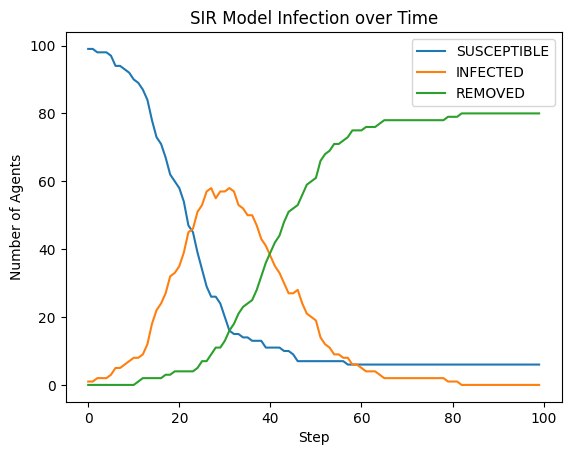

In [29]:
df = model_sir_spreader.datacollector.get_agent_vars_dataframe()
states_over_steps = df.groupby("Step").value_counts().unstack(fill_value=0)

plt.plot(states_over_steps[0], label='SUSCEPTIBLE')
plt.plot(states_over_steps[1], label='INFECTED')
plt.plot(states_over_steps[2], label='REMOVED')
plt.title('SIR Model Infection over Time')
plt.xlabel('Step')
plt.ylabel('Number of Agents')
plt.legend()

plt.savefig('SIR_spreader.png', dpi=300)
plt.savefig('SIR_spreader.pdf')
plt.show()

#### 4.2.5 Visualize k-shell decomposition result

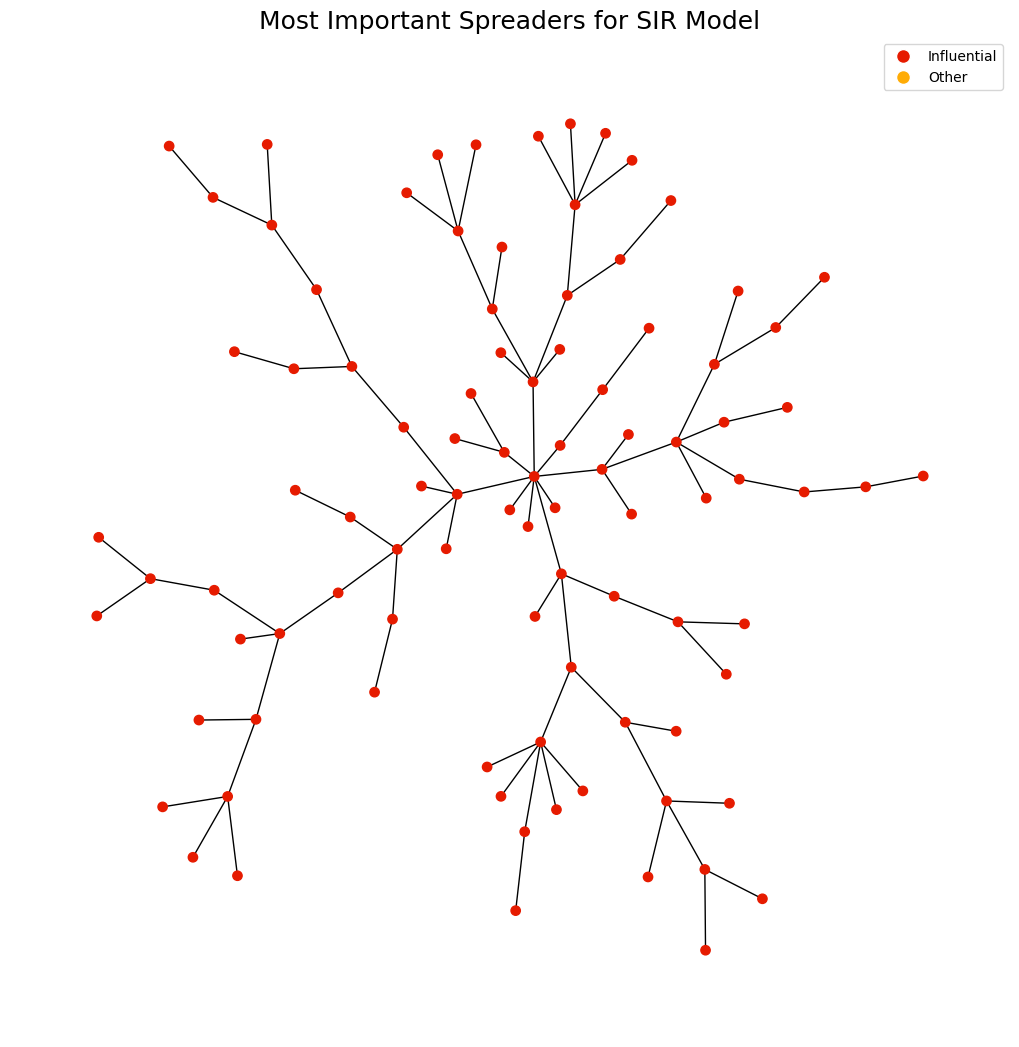

In [30]:
agents = model_sir_spreader.schedule.agents
agents.extend(model_sir_spreader.dead_agents)

G = nx.Graph()
for agent in agents:
    for other_id in agent.contact_list:
        G.add_edge(agent.unique_id, other_id)

most_influential_nodes = k_shell_decomposition(G.copy())

color_map = ['#e61b00' if node in most_influential_nodes else '#ffac06' for node in G]

options = {
    'node_size': 45,             # size of nodes
    'width': 1,                  # line width of edges
    'edge_color': 'black',       # edge color
}

# Draw the initial graph
plt.figure(figsize=(10, 10))
nx.draw_kamada_kawai(G, node_color=color_map, with_labels=False, arrows=False, **options)

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Influential', markerfacecolor='#e61b00', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Other', markerfacecolor='#ffac06', markersize=10)]

plt.legend(handles=legend_elements, loc='upper right')
plt.title('Most Important Spreaders for SIR Model', fontsize=18)

plt.savefig('SIR_k_shell.png', dpi=300)
plt.savefig('SIR_k_shell.pdf')
plt.show()

### 4.3 Now try SIS Model

#### 4.3.1 SIS Agent with Vaccination

After a infection, agent have a 9% chance of a reinfaction: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7988582/

* During the observation period from September 1 to November 30, we recorded 40 tentative re‐infections in the COVID‐19 survivor group (0.27%), and 253 581 new infections in the general population group (2.85%).
* The OR (with 95% CI) for infections in the COVID‐19 survivor group versus the general population group was 0.09 (95% CI, 0.07 to 0.13).
* The mean (± standard deviation) time from the first to the tentative re‐infection was 212 ± 25 days.

In [31]:
class SISAgentVaccinatedSpreader(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.age = get_age()
        model.agent_ages.append(self.age)
        self.death_prob = get_death_prob(self.age)
        self.state = State.SUSCEPTIBLE
        self.infection_time = 0
        self.contact_list = []
        self.vaccinated = False
        self.was_infected = False

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def status(self):
        if self.state == State.INFECTED:
            if np.random.random() < self.death_prob: # chance of "dying"
                self.model.schedule.remove(self)
                self.model.dead_agents.append(self)
            else:
                t = self.model.schedule.time - self.infection_time
                if t >= self.recovery_time:
                    self.state = State.SUSCEPTIBLE # Not Removed

    def contact(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        for other in cellmates:
            if self.random.random() <= self.model.ptrans: #  transmission probability
                if (self.state is State.INFECTED and other.state is State.SUSCEPTIBLE):
                    if not other.vaccinated or np.random.random() > other.model.vaccination_protection:
                        if not other.was_infected or np.random.random() <= 0.09: # 9%
                            other.state = State.INFECTED
                            other.infection_time = self.model.schedule.time
                            other.recovery_time = self.model.get_recovery_time()
                            self.contact_list.append(other.unique_id)
                            other.was_infected = True

    def step(self):
        self.status()
        self.move()
        self.contact()

#### 4.3.2 SIS Model with Vaccination

In [32]:
class SISModelVaccinatedSpreader(Model):
    def __init__(self, N, ptrans, vacc_protection, vaccination_time, vacc_proportion, recovery_days, recovery_sd,
                 initial_infections, width, height):

        super().__init__()

        self.num_agents = N
        self.ptrans = ptrans
        self.vaccination_protection = vacc_protection
        self.time_of_vaccination = vaccination_time
        self.proportion_of_vaccines = vacc_proportion
        self.recovery_days = recovery_days
        self.recovery_sd = recovery_sd

        self.grid = MultiGrid(width, height, True) # each cell can contain more than one agent
        self.schedule = RandomActivation(self)
        self.running = True

        self.agent_ages = []
        self.dead_agents = []

        self.datacollector = DataCollector(
            model_reporters={"Nr_Deaths": get_number_of_deaths},
            agent_reporters={"State": "state"})

        # Create agents
        for id in range(self.num_agents):
            agent = SISAgentVaccinatedSpreader(id, self)
            self.schedule.add(agent)

            # Place random on grid
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(agent, (x, y))

        # Only make one agent infected
        first_agent = self.schedule.agents[0]
        first_agent.state = State.INFECTED
        first_agent.recovery_time = self.get_recovery_time()

    # Calculates recovery time for an agent based on a normal distribution
    # with mean (recovery_days) and standard deviation (recovery_sd).
    def get_recovery_time(self):
        return int(self.random.normalvariate(self.recovery_days, self.recovery_sd))

    def step(self):
        self.datacollector.collect(self)

        if self.schedule.time == self.time_of_vaccination: # At step t vaccinate proportion of agents
            num_agents = len(self.schedule.agents)
            num_to_sample = int(self.proportion_of_vaccines * num_agents)
            sampled_agents = np.random.choice(self.schedule.agents, size=num_to_sample, replace=True)
            for agent in sampled_agents:
                agent.vaccinated = True

        self.schedule.step()

#### 4.3.3 Run the model without batch runner


*   Only 100 agents for better visibility
*   TP of 50%
*   80% of Agents get vaccinated at step 5
*   Vaccination protection is 80%

In [47]:
params = {'N': 100,
          'ptrans': 0.5,
          'vacc_protection': 0.8,
          'vaccination_time': 5,
          'vacc_proportion': 0.5,
          'recovery_days': 21,
          'recovery_sd': 7,
          'initial_infections': 0.02,
          'width': 10,
          'height': 10}

model_sis_spreader = SISModelVaccinatedSpreader(params['N'], params['ptrans'], params['vacc_protection'],
                                                params['vaccination_time'], params['vacc_proportion'],
                                                params['recovery_days'], params['recovery_sd'],
                                                params['initial_infections'], params['width'], params['height'])

while model_sis_spreader.schedule.steps < 100:
    model_sis_spreader.step()

#### 4.3.4 Visualize SIR Model for given parameters

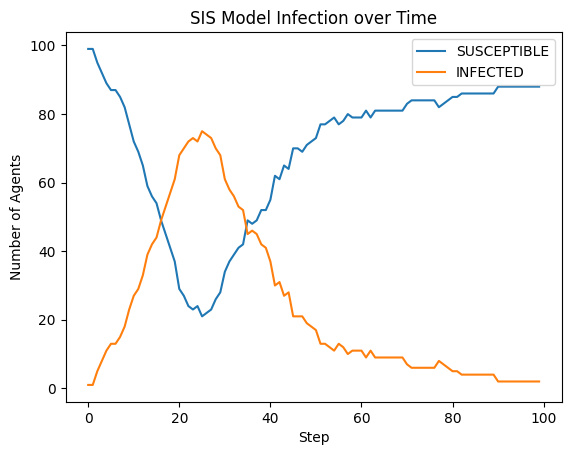

In [48]:
df = model_sis_spreader.datacollector.get_agent_vars_dataframe()
states_over_steps = df.groupby("Step").value_counts().unstack(fill_value=0)

plt.plot(states_over_steps[0], label='SUSCEPTIBLE')
plt.plot(states_over_steps[1], label='INFECTED')
plt.title('SIS Model Infection over Time')
plt.xlabel('Step')
plt.ylabel('Number of Agents')
plt.legend()

plt.savefig('SIS_spreader.png', dpi=300)
plt.savefig('SIS_spreader.pdf')
plt.show()

#### 4.3.5 Fake Parameters lol



In [63]:
params = {'N': 100,
          'ptrans': 0.5,
          'vacc_protection': 0.8,
          'vaccination_time': 5,
          'vacc_proportion': 0.5,
          'recovery_days': 21,
          'recovery_sd': 7,
          'initial_infections': 0.02,
          'width': 16,
          'height': 16}

model_sis_spreader = SISModelVaccinatedSpreader(params['N'], params['ptrans'], params['vacc_protection'],
                                                params['vaccination_time'], params['vacc_proportion'],
                                                params['recovery_days'], params['recovery_sd'],
                                                params['initial_infections'], params['width'], params['height'])

while model_sis_spreader.schedule.steps < 100:
    model_sis_spreader.step()

#### 4.3.6 Visualize k-shell decomposition result for SIS

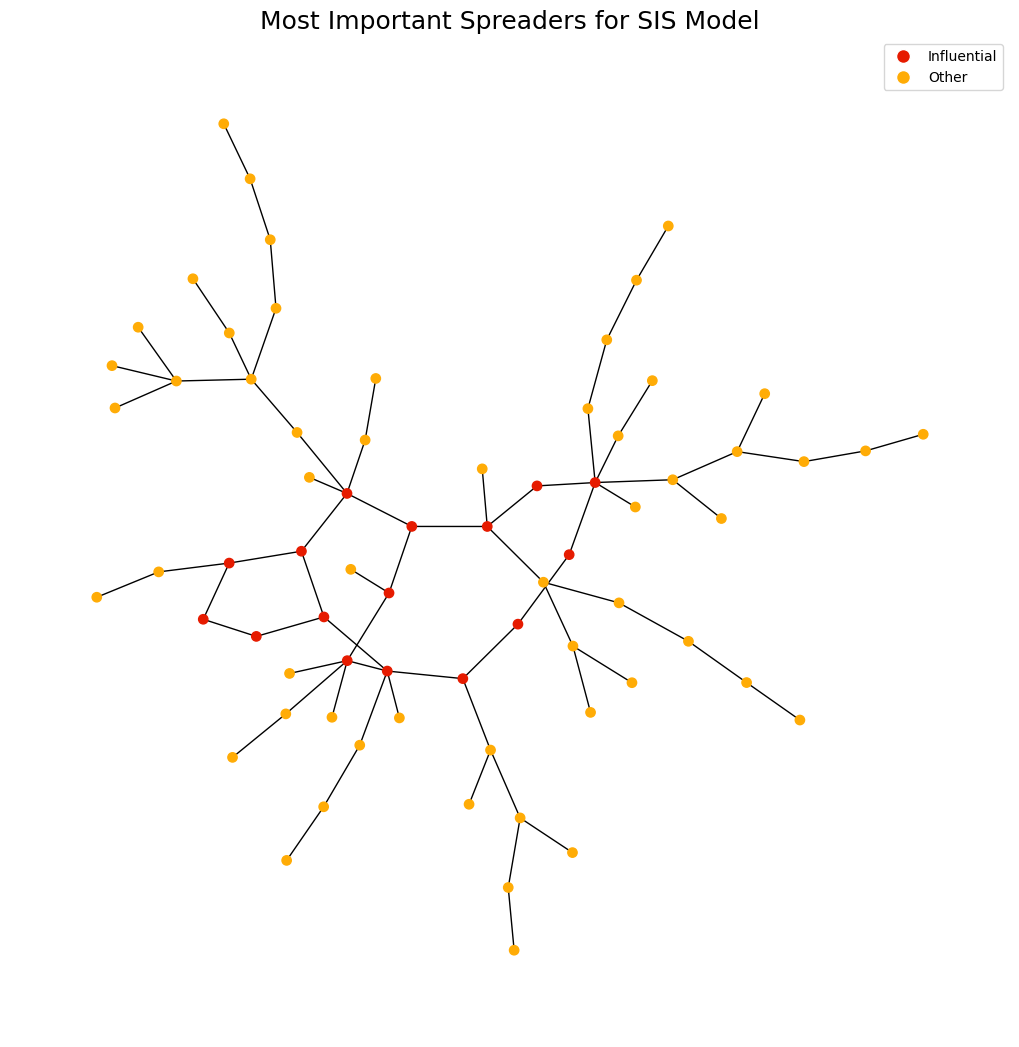

In [64]:
agents = model_sis_spreader.schedule.agents
agents.extend(model_sis_spreader.dead_agents)

G = nx.Graph()
for agent in agents:
    for other_id in agent.contact_list:
        G.add_edge(agent.unique_id, other_id)

most_influential_nodes = k_shell_decomposition(G.copy())

color_map = ['#e61b00' if node in most_influential_nodes else '#ffac06' for node in G]

options = {
    'node_size': 45,             # size of nodes
    'width': 1,                  # line width of edges
    'edge_color': 'black',       # edge color
}

# Draw the initial graph
plt.figure(figsize=(10, 10))
nx.draw_kamada_kawai(G, node_color=color_map, with_labels=False, arrows=False, **options)

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Influential', markerfacecolor='#e61b00', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Other', markerfacecolor='#ffac06', markersize=10)]

plt.legend(handles=legend_elements, loc='upper right')
plt.title('Most Important Spreaders for SIS Model', fontsize=18)

plt.savefig('SIS_k_shell.png', dpi=300)
plt.savefig('SIS_k_shell.pdf')
plt.show()

#### 4.3.7 Check how many influential spreaders are vaccinated

In [65]:
sum_vaccinated = 0
for agent in agents:
    if agent.unique_id in most_influential_nodes and agent.vaccinated:
        sum_vaccinated += 1

prop = sum_vaccinated / len(most_influential_nodes)
print(f"{round(prop * 100, 2)}% of most influential spreaders are vaccinated, {round((1-prop)*100, 2)}% of not vaccinated")


18.75% of most influential spreaders are vaccinated, 81.25% of not vaccinated
